In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.datasets import load_digits
digits = load_digits()
images = np.load('../test_windows.npy')

### Introduction
Using a stack of images consisting of regions surrounding detected patterns on Hi-C maps.
All patterns should represent the same type (e.g. chromatin loop), but some are false positives.
The idea is to exclude the false positive based on their appearance.

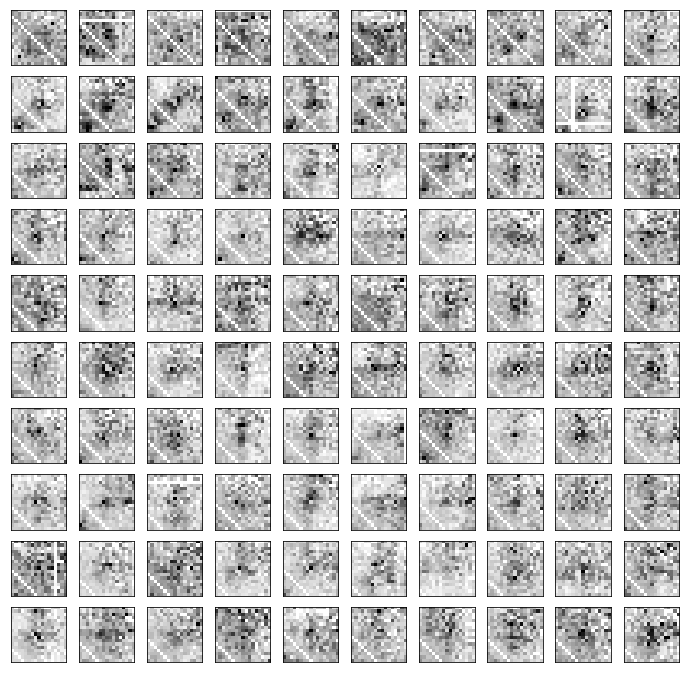

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
r = c = int(np.floor(np.sqrt(images.shape[0])))
if images.shape[0] > 100:
    r = c = 10
fig, axes = plt.subplots(r, c, figsize=(12, 12), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i, :, :], cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.text(1, 1, str(digits.target[i]), transform=ax.transAxes, color='blue')

### Preprocessing
Patterns should be comparable so we need to correct for baseline signal due to local background and smooth noisy regions out.

In [3]:
import scipy.ndimage as ndi
images = ndi.gaussian_filter(images, sigma=0.6)

for i in range(images.shape[0]):
    m = images[i, :, :].copy()
    images[i, :, :] -= np.mean(m)
    images[i, :, :] /= np.std(m)

In [4]:
images.shape

(2723, 17, 17)

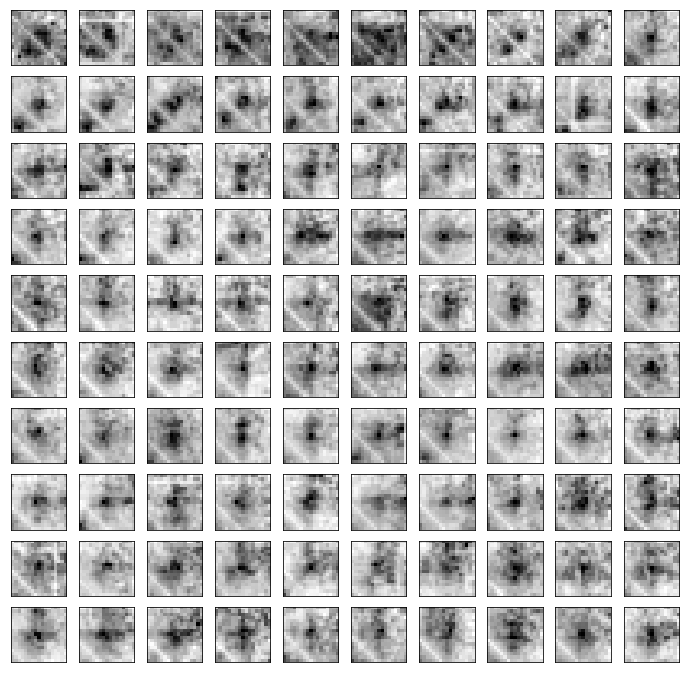

In [5]:
fig, axes = plt.subplots(r, c, figsize=(12, 12), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i, :, :], cmap=plt.cm.gray_r, interpolation='nearest')
    #ax.text(1, 1, str(digits.target[i]), transform=ax.transAxes, color='blue')

Each pixel of each window is used as a feature. This is done by flattening the images into 1D stripes.

In [4]:
n, x, y = images.shape

data = np.reshape(images, (n, x*y))

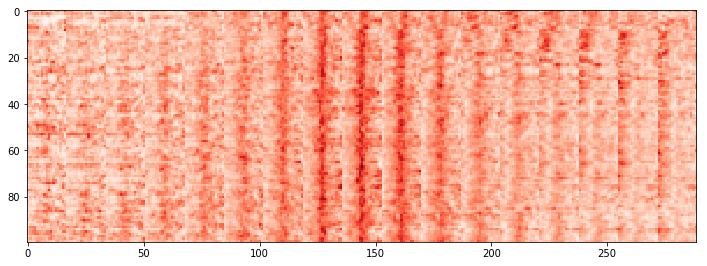

In [5]:
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.imshow(data[:100], cmap="Reds")

Each image can be visualised as a curve where the y axis is the sum for a given bin and the x axis is the offset from center. A loop should have a negative correlation between the absolute offset from center and the sum in bins. Everything is transformed into zscore to make windows comparable and each line (window) is colored according to offset-zscore correlation.

In [8]:
import seaborn as sns
import scipy.stats as st
# Compute mean of col and row sum for each image and get into 1D
bands = (images.sum(axis=1) + images.sum(axis=2)) / 2
# Set each 'bin' to a zscore
bands = st.zscore(bands, axis=1)
bands = pd.DataFrame(bands)
bands['idx'] = bands.index
bands = bands.melt(id_vars='idx')
bands.columns = ["img", 'bin', 'zscore']
bands.bin -= np.max(bands.bin) // 2
corr = bands.groupby("img").apply(lambda g: np.round(st.pearsonr(np.abs(g.bin), g.zscore)[0], 2))
bands = bands.merge(pd.DataFrame({'corr': corr.values, 'img': corr.index}), on=['img'])
bands = bands.sort_values('corr')


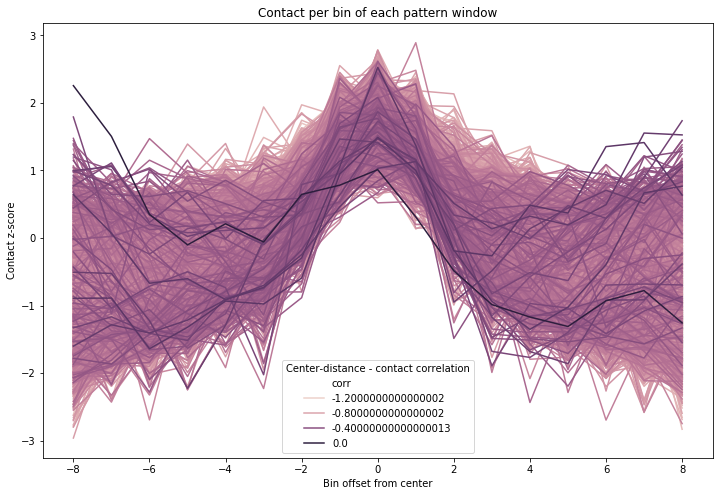

In [9]:
%matplotlib inline
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=bands, x='bin', y='zscore', estimator=None, units='img', hue='corr')
ax.set_title("Contact per bin of each pattern window")
ax.set_ylabel("Contact z-score")
ax.set_xlabel("Bin offset from center")
plt.legend(title="Center-distance - contact correlation")
plt.show()

Text(0.5, 0, 'Correlation coefficient')

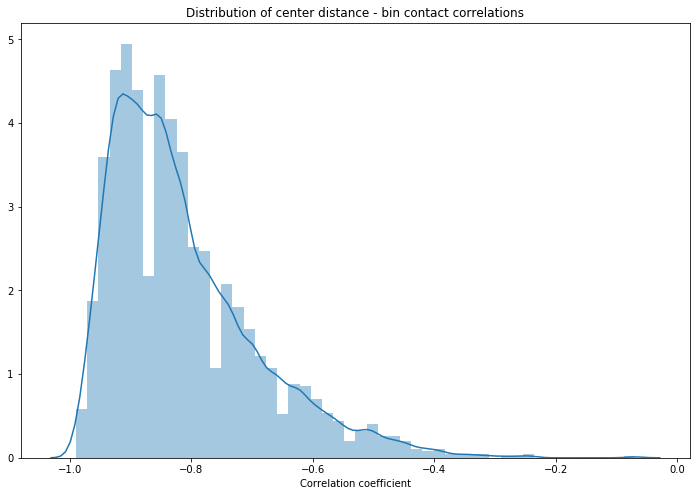

In [10]:
plt.figure(figsize=(12, 8))
hist = sns.distplot(bands['corr'])
hist.set_title("Distribution of center distance - bin contact correlations")
hist.set_xlabel("Correlation coefficient")

We can aggregate all lines to see the general trend with CI 95%:

Text(0.5, 0, 'Bin offset from center')

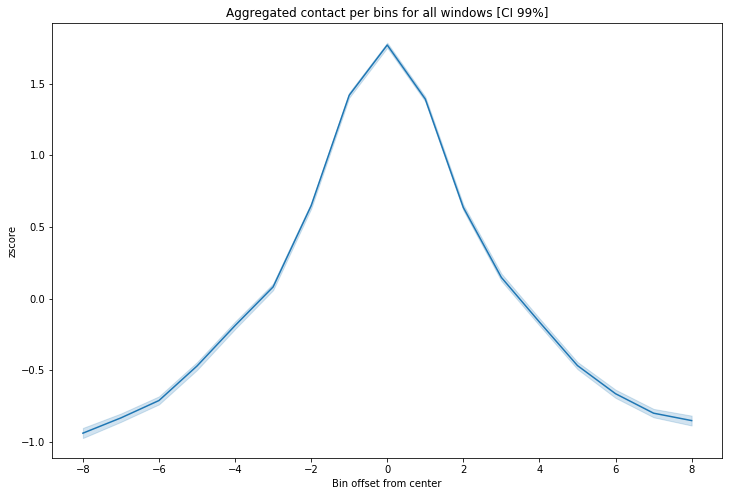

In [11]:
%matplotlib inline
plt.figure(figsize=(12, 8))
ax = sns.lineplot(data=bands, x='bin', y='zscore', ci=99)
ax.set_title("Aggregated contact per bins for all windows [CI 99%]")
ax.set_xlabel("Bin offset from center")

### Clustering

First attempt using Birch clustering, but ideally we should use a clustering algorithm such as DBSCAN that does not required prior knowledge of the number of clusters.


In [12]:
from sklearn.cluster import Birch
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
n_clusters = 3
d_cl = Birch(n_clusters=n_clusters)
pred = d_cl.fit_predict(data)

Cluster centroids can be visualized to identify which clusters represent patterns of interest, or simply noise from various types of false positive signals.

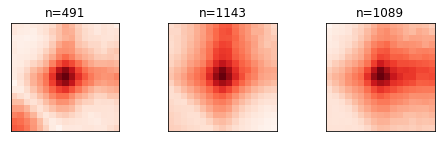

In [13]:
clustering = 'birch'

# Visualise cluster centroid (pixels are dimensions) to see "typical number" in cluster
#plt.figure(figsize=(100,100))
f, axes = plt.subplots(1, n_clusters, figsize=(8, 2), subplot_kw=dict(xticks=[], yticks=[]))
for ax, i in zip(axes.flat, range(len(np.unique(d_cl.labels_)))):
    if clustering == 'kmeans':
        centroid = np.reshape(d_cl.cluster_centers_[i, :], (x, y))
    else:
        centroid = np.apply_along_axis(np.median, 0, images[d_cl.labels_ == i])
    ax.imshow(centroid, cmap='Reds')
    ax.set_title(f"n={len(d_cl.labels_[d_cl.labels_ == i])}")

Green windows are patterns that clustered with the main cluster (largest) and red are those that did not. K-means clustering does not work so well apparently. Perhaps we can fix that by combining a naive clustering method and PCA....

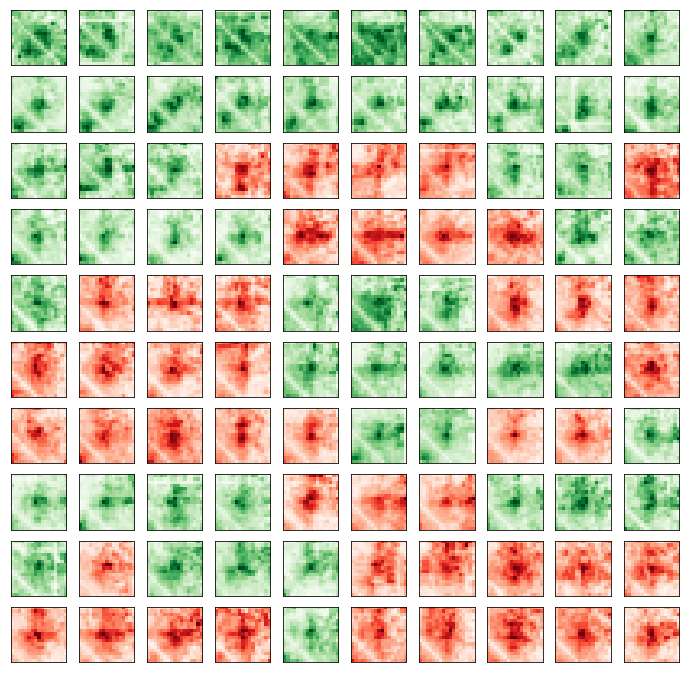

In [14]:
%matplotlib inline
clusters, counts = np.unique(d_cl.labels_[:100], return_counts=True)
largest_cluster = clusters[np.where(counts == max(counts))[0]][0]
largest_cluster

fig, axes = plt.subplots(10, 10, figsize=(12, 12), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    if d_cl.labels_[i] == largest_cluster:
        cmap="Greens"
    else:
        cmap="Reds"
    ax.imshow(images[i, :, :], cmap=cmap, interpolation='nearest')
    #ax.text(1, 1, str(digits.target[i]), transform=ax.transAxes, color='blue')


### Reducing dimensions
Reducing dimensions could allow separating noise from information in those windows and make the clustering more stable.

In [15]:
from sklearn.decomposition import PCA

def pca_transform(data, n=8):
    pca = PCA(n_components=n, random_state=1)
    pca.fit(data)
    evar = pca.explained_variance_ratio_.sum()
    pcas = pca.transform(data)
    reduced = pca.inverse_transform(pcas)
    return reduced, pcas, evar

First, we need to estimate the number of principal components required to retain a target proportion of variance. We'll consider we want to keep 70% of pixel variance

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

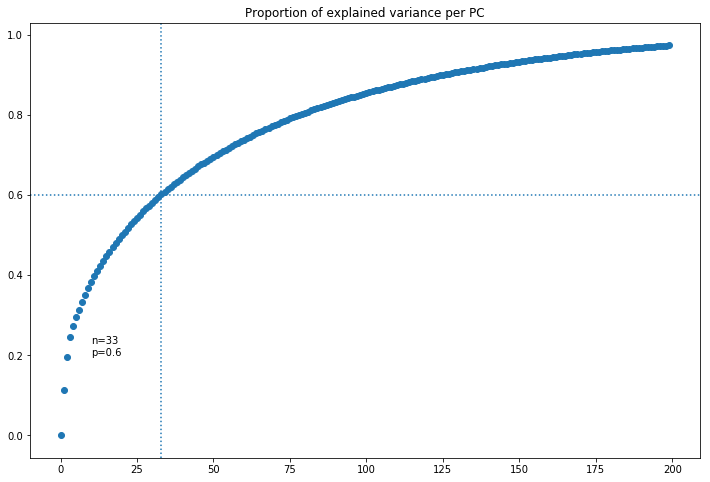

In [16]:
%matplotlib inline
pc_range = 200
expl_var = [0 for i in range(pc_range)]
for i in range(pc_range):
    _, _, v = pca_transform(data, n=i)
    expl_var[i] = v
    
target_prop = 0.6
diff_expl = np.abs(np.array(expl_var) - target_prop)
n_pc_req = np.where(diff_expl == min(diff_expl))[0][0]
plt.figure(figsize=(12, 8))
plt.scatter(range(len(expl_var)), expl_var)
plt.axhline(y=target_prop, ls=':')
plt.axvline(x=n_pc_req, ls=':')
plt.title("Proportion of explained variance per PC")
plt.text(x=10, y=0.2, s=f"n={n_pc_req}\np={target_prop}")
plt.set_xlabel("Number of PCs used")
plt.set_ylabel("Proportion of explained variance")

In [18]:
reduced, pcas, evar = pca_transform(data, n=n_pc_req)

We can then use the invert PCA transform to convert images back from PC space to pixel space. This will yield "simplified" images with some of the variance removed.

In [19]:
n_clusters = 3
d_cl = Birch(n_clusters=n_clusters)
pred = d_cl.fit_predict(reduced)

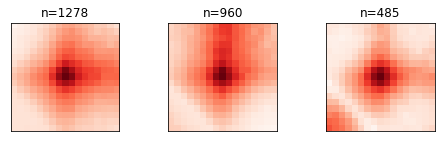

In [20]:
f, axes = plt.subplots(1, n_clusters, figsize=(8, 2), subplot_kw=dict(xticks=[], yticks=[]))
for ax, i in zip(axes.flat, range(len(np.unique(d_cl.labels_)))):
    if clustering == 'kmeans':
        centroid = np.reshape(d_cl.cluster_centers_[i, :], (x, y))
    else:
        centroid = np.apply_along_axis(np.median, 0, images[d_cl.labels_ == i])
    ax.imshow(centroid, cmap='Reds')
    ax.set_title(f"n={len(d_cl.labels_[d_cl.labels_ == i])}")

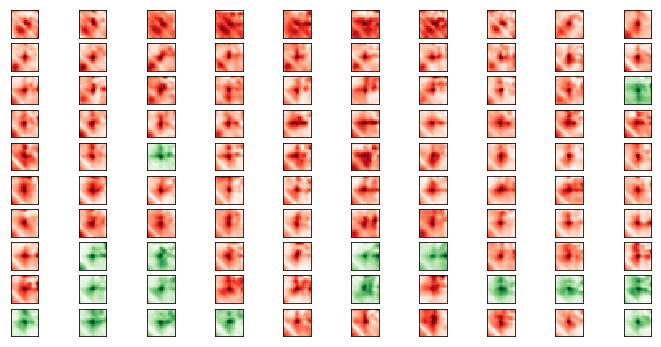

In [21]:
%matplotlib inline
clusters, counts = np.unique(d_cl.labels_, return_counts=True)
largest_cluster = clusters[np.where(counts == max(counts))[0]][0]
largest_cluster

fig, axes = plt.subplots(r, c, figsize=(12, 6), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    if d_cl.labels_[i] == largest_cluster:
        cmap="Greens"
    else:
        cmap="Reds"
    
    ax.imshow(np.reshape(reduced[i, :], (x, y)), cmap=cmap, interpolation='nearest')

All PCs contain only a small amount of information and there is no visible structure.

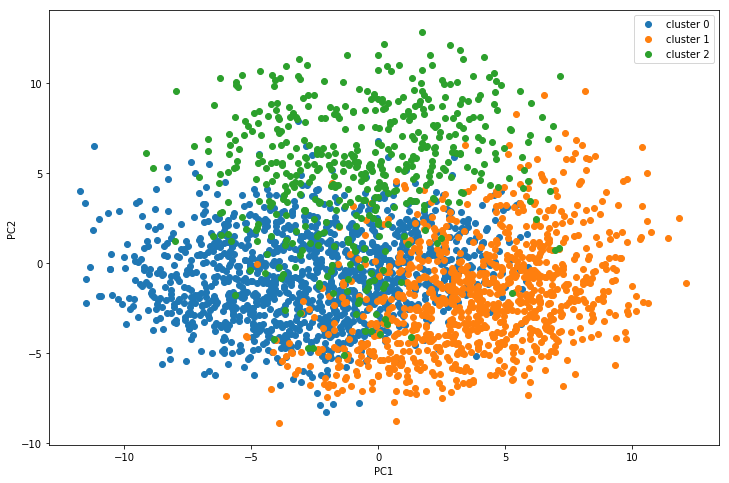

In [22]:
pc_a, pc_b = 0, 1
fig, ax1 = plt.subplots(figsize=(12, 8))
for i in range(len(np.unique(d_cl.labels_))):
    cl_points = d_cl.labels_ == i
    ax1.scatter(pcas[cl_points, pc_a], pcas[cl_points, pc_b], label=f'cluster {i}')
plt.xlabel(f'PC{pc_a+1}')
plt.ylabel(f'PC{pc_b+1}')
plt.legend()


In [23]:
pca_df = pd.DataFrame(pcas[:, :5])
pca_df['label'] = d_cl.labels_

/home/cmatthey/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/cmatthey/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


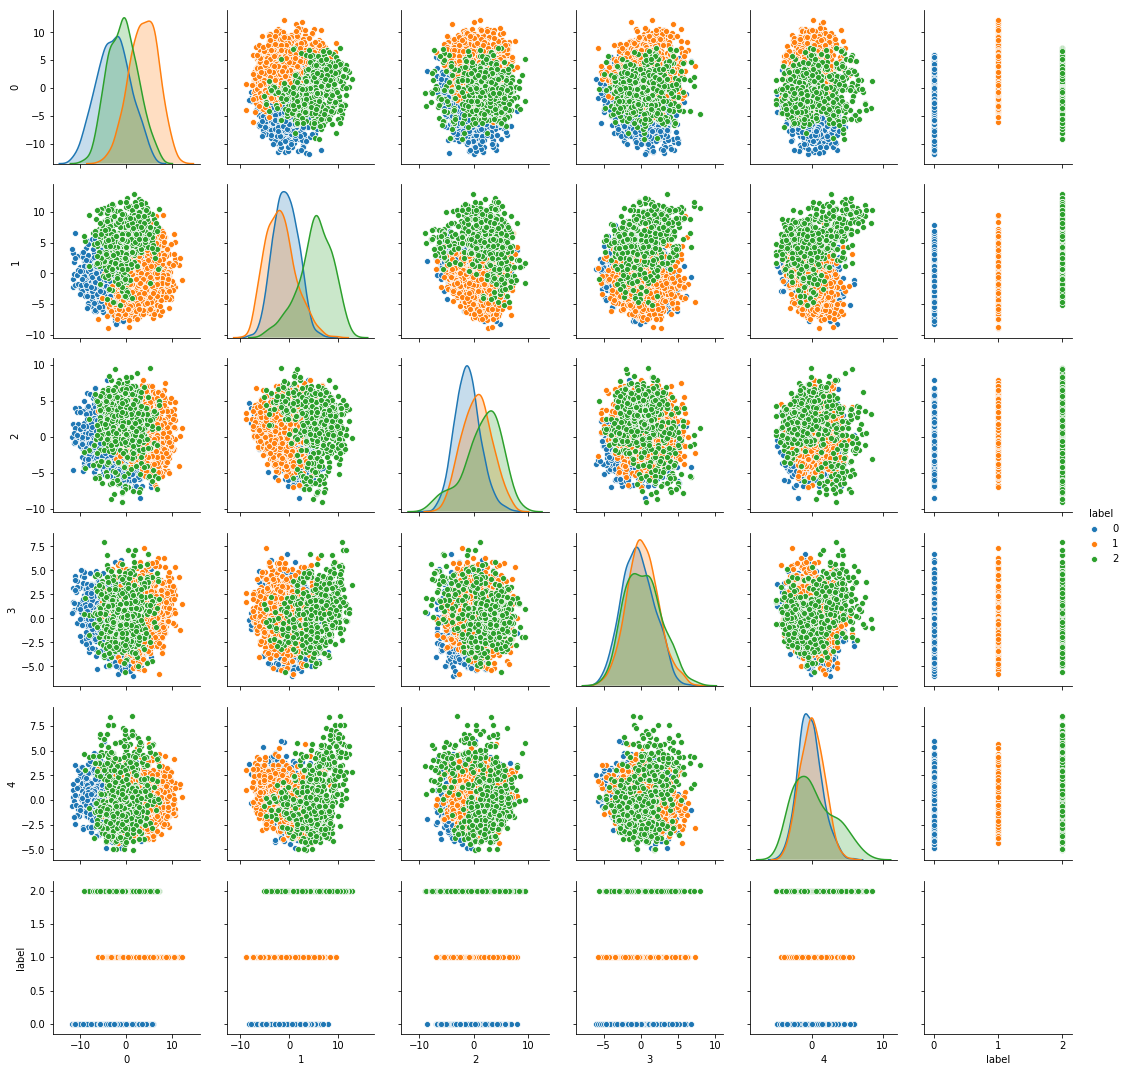

In [24]:
sns.pairplot(pca_df, hue='label')

In [6]:
from sklearn.manifold import TSNE
t_sne = TSNE(n_components=2, perplexity=15, random_state=1).fit_transform(data)

In [7]:
from sklearn.cluster import DBSCAN
clustering="DBSCAN"
d_cl = DBSCAN(eps=7,min_samples=10)
pred = d_cl.fit_predict(t_sne)

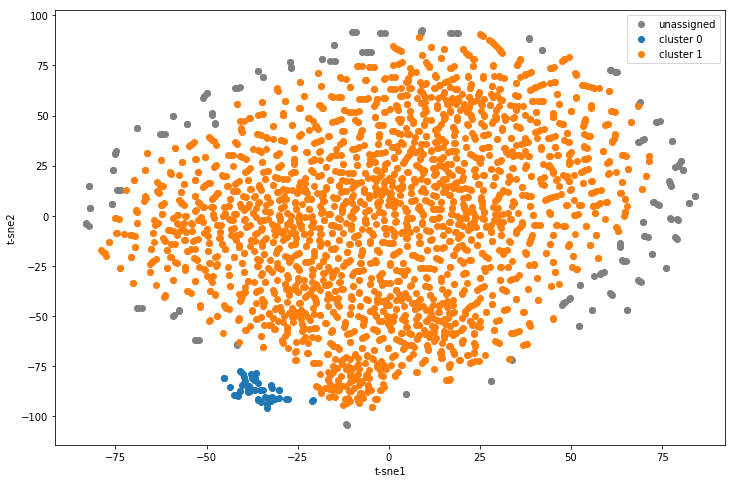

In [8]:
pc_a, pc_b = 0, 1
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.scatter(t_sne[d_cl.labels_ == -1, pc_a], t_sne[d_cl.labels_ == -1, pc_b], label='unassigned', c='grey')
for i in range(len(np.unique(d_cl.labels_))-1):
    cl_points = d_cl.labels_ == i
    ax1.scatter(t_sne[cl_points, pc_a], t_sne[cl_points, pc_b], label=f'cluster {i}')
plt.xlabel(f't-sne{pc_a+1}')
plt.ylabel(f't-sne{pc_b+1}')
plt.legend()


Text(0.5, 0.98, 'pileup of DBSCAN clusters')

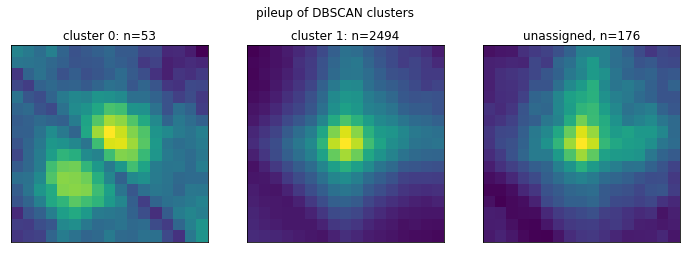

In [17]:
# Visualise cluster centroid (pixels are dimensions) to see "typical number" in cluster
#plt.figure(figsize=(100,100))
# NOTE: DBSCAN gives label -1 to points without cluster
n_clusters = len(np.unique(d_cl.labels_)) - 1
f, axes = plt.subplots(1, n_clusters+1, figsize=(12, 4), subplot_kw=dict(xticks=[], yticks=[]))
centroid = np.apply_along_axis(np.median, 0, images[d_cl.labels_ == -1])
axes[2].imshow(centroid)
axes[2].set_title(f"unassigned, n={len(d_cl.labels_[d_cl.labels_ == -1])}")
for ax, i in zip(axes.flat, range(n_clusters)):
    if clustering == 'kmeans':
        centroid = np.reshape(d_cl.cluster_centers_[i, :], (x, y))
    else:
        centroid = np.apply_along_axis(np.median, 0, images[d_cl.labels_ == i])
    ax.imshow(centroid)
    ax.set_title(f"cluster {i}: n={len(d_cl.labels_[d_cl.labels_ == i])}")
plt.suptitle("pileup of DBSCAN clusters")

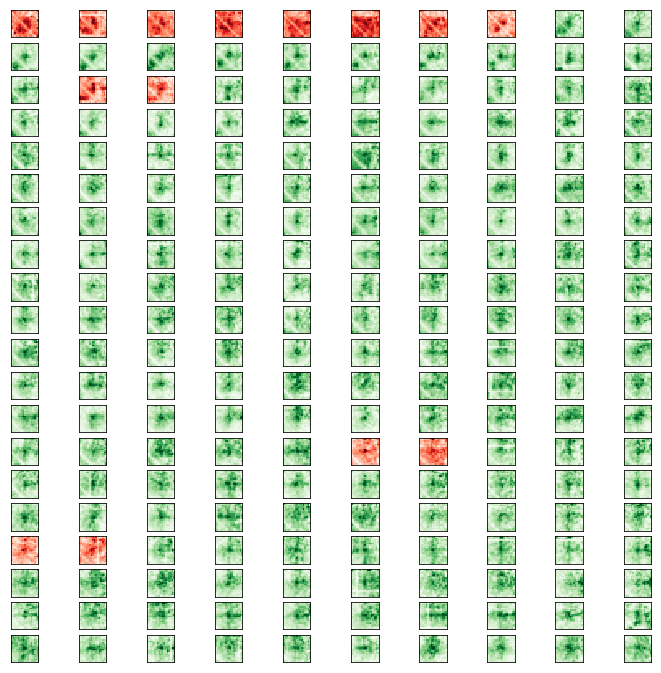

In [30]:
%matplotlib inline
clusters, counts = np.unique(d_cl.labels_, return_counts=True)
largest_cluster = clusters[np.where(counts == max(counts))[0]][0]
largest_cluster

fig, axes = plt.subplots(2*r, c, figsize=(12, 12), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    if d_cl.labels_[i] == largest_cluster:
        cmap="Greens"
    else:
        cmap="Reds"
    
    ax.imshow(np.reshape(images[i, :], (x, y)), cmap=cmap, interpolation='nearest')

### Interactive visualisation


In [9]:
from bokeh.plotting import figure, output_file, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
from tempfile import mkdtemp
from os.path import join
import os
from PIL import Image

def build_source(x_data, y_data, labels, images, img_dir=None):
    colors = ['orange', 'blue', 'green', 'purple', 'grey']
    label_colors = [colors[i] for i in labels]
    if img_dir:
        os.makedirs(img_dir, exist_ok=True)
    else:
        img_dir = mkdtemp()
    imgs = ['' for i in range(images.shape[0])]
    for i, v in enumerate(images):
        imgs[i] = join(img_dir, f"pattern_{i}.jpeg")
        if not os.path.isfile(imgs[i]):
            img = v.copy()
            img -= np.min(img)
            img = np.abs(img)
            img *= (255 / np.max(img))
            im = Image.fromarray(np.uint8(img), "L")
            im.save(imgs[i])
    source = ColumnDataSource(
            data=dict(
                x=x_data,
                y=y_data,
                color=label_colors,
                desc=list(range(len(x_data))),
                imgs = imgs,
                mats = images
            )
        )
    return source

# Pick 100 random images
samples = np.random.choice(n, 10, replace=False)
source = build_source(t_sne[:, 0], t_sne[:, 1], d_cl.labels_, images, img_dir='bokeh_patterns')

In [10]:
output_file("toolbar.html")
#output_notebook()


hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <img
                    src="@imgs" height="90" alt="@imgs" width="90"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span>
                <span style="font-size: 15px; color: #966;">[$index]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;">($x, $y)</span>
            </div>
        </div>
        """
    )

p = figure(plot_width=800, plot_height=800, tools=[hover],
           title="Detected patterns in t-sne embedding")
p.xaxis.axis_label = f't-sne {pc_a+1}'
p.yaxis.axis_label = f't-sne {pc_b+1}'
p.circle('x', 'y', size=10, fill_color='color', source=source)

show(p)

In [5]:


from bokeh.io import output_file, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.plotting import figure
#output_file("brushing.html")
output_notebook()

x = list(range(-20, 21))
y0 = [abs(xx) for xx in x]
y1 = [xx**2 for xx in x]


hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <img
                    src="@imgs" height="90" alt="@imgs" width="90"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">@desc</span>
                <span style="font-size: 15px; color: #966;">[$index]</span>
            </div>
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; color: #696;">($x, $y)</span>
            </div>
        </div>
        """
    )
TOOLS = "box_select,lasso_select,help"

# create a new plot and add a renderer
left = figure(tools=[hover, TOOLS], plot_width=600, plot_height=600, title="Detected patterns in t-sne embedding")
left.circle('x', 'y', source=source)

# create another new plot and add a renderer
right = figure(plot_width=300, plot_height=300, title=None)
right.circle('x', 'y', source=source)

x_pix, y_pix = images[0, :, :].shape
# create a figure, setting the x and y ranges to the appropriate data bounds
p1 = figure(title="Pileup", plot_width=300, plot_height=300,
            x_range = [0, x_pix], y_range = [0, y_pix])

# Fill in the missing parameters to use the `image` renderer to
# display the Mandelbrot image color mapped with the palette 'Spectral11'
#
# NOTE: the `image` renderer can display many images at once, so it takes
# **lists** of images, coordinates, and palettes. Remember to supply sequences
# for these parameters, even if you are just supplying one.
s2 = ColumnDataSource(data=dict(img=[np.zeros((17, 17)).tolist()], xmin=[0], ymin=[0], dw=[x_pix], dh=[y_pix]))
p1.image(image="img",             # image data
         x="xmin",               # lower left x coord
         y="ymin",               # lower left y coord
         dw="dw",        # *data space* width of image
         dh="dh",        # *data space* height of image
         palette="Spectral11",    # palette name
         source=s2
)

#p.line(x=[0, 1], y='ym', color="orange", line_width=5, alpha=0.6, source=s2)

source.callback = CustomJS(args=dict(s2=s2), code="""
        var inds = cb_obj.get('selected')['1d'].indices;
        var d = cb_obj.get('data');
        var vpix = d['mats'][0].length;
        var hpix = d['mats'][0][0].length;
        var img = new Array(vpix);

        for (var i = 0; i < vpix; i++) {
          x[i] = new Array(hpix);
        }

        if (inds.length == 0) { return; }

        for (i = 0; i < inds.length; i++) {
            for x = 0; x < vpix; x++){
                for y = 0; y < vpix; y++){
                    img[x][y] += d['mats'][inds[i]][x][y];
                }
            }
        }
        s2.get('data')['img'][0] = img;
        cb_obj.trigger('change');
        s2.trigger('change');
    """)

p = gridplot([[left, p1]])

show(p)

Loading BokehJS ...

NameError: name 'HoverTool' is not defined

In [11]:
from random import random

from bokeh.layouts import row
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.plotting import figure, output_notebook, show
output_notebook()


x = [random() for x in range(500)]
y = [random() for y in range(500)]

s1 = ColumnDataSource(data=dict(x=x, y=y))
p1 = figure(plot_width=400, plot_height=400, tools="lasso_select", title="Select Here")
p1.circle('x', 'y', source=s1, alpha=0.6)

s2 = ColumnDataSource(data=dict(x=[], y=[]))
p2 = figure(plot_width=400, plot_height=400, x_range=(0, 1), y_range=(0, 1),
            tools="", title="Watch Here")
p2.circle('x', 'y', source=s2, alpha=0.6)

callback = CustomJS(args=dict(s1=s1, s2=s2), code="""
        var inds = cb_obj.indices;
        var d1 = s1.data;
        var d2 = s2.data;
        d2['x'] = []
        d2['y'] = []
        for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]]*2)
            d2['y'].push(d1['y'][inds[i]])
        }
        s2.change.emit();
"""
)
                    
debug_callback = CustomJS(args=dict(s1=s1, s2=s2), code="""
    var inds = cb_obj.indices;
    var d1 = s1.data;
    var d2 = s2.data;
    d2['x'] = []
    d2['y'] = []
    for (var i = 0; i < inds.length; i++) {
            d2['x'].push(d1['x'][inds[i]])
            d2['y'].push(d1['y'][inds[i]])
        }
    s2.change.emit();
"""
)

s1.selected.js_on_change('indices',debug_callback )

layout = row(p1, p2)

show(layout)

Loading BokehJS ...